In [2]:
from PIL import Image
import os
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import splitfolders
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, pooling
from keras.utils import np_utils, to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
import splitfolders
import random

In [3]:
categories = [("PET", 1), ("PS", 2), ("PP", 3), ("PE", 4)] # 2992 / 2992 / 3001 / 2776 = > 11,761

X, y = [], []

In [3]:
splitfolders.ratio("input", output="output", seed=1337, ratio=(0.9, 0.1))

Copying files: 11761 files [04:01, 48.66 files/s] 


In [5]:
for i, v in enumerate(categories) : 
    # one-hot encoding
    label = [0 for _ in range(len(categories))]
    label[i] = 1

    image_dir = "./output/train/" + v[0] + "_IMG/*.jpg"
    files = glob.glob(image_dir)
    for file in files :
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((64, 64))
        data = np.asarray(image)

        X.append(data)
        y.append(label)

<PIL.Image.Image image mode=RGB size=200x214 at 0x1872F4E8550>
<PIL.Image.Image image mode=RGB size=64x64 at 0x1872F4E8520>
(64, 64, 3)


In [6]:
X = np.array(X)
y = np.array(y)


print(len(X))
print(len(y))
print(X.shape)
print(y.shape)

2
2
(2, 64, 64, 3)
(2, 4)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=219)
xy = (X_train, X_test, y_train, y_test)
np.save("./muli_image_data_ann.npy", xy)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [7]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2] * X_train.shape[3])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2] * X_test.shape[3])
print(X_train.shape)
print(X_test.shape)

(8465, 12288)
(2117, 12288)


In [8]:
# 일반화
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [9]:
# 모형 구조 정의하기
model = Sequential()
model.add(Dense(512, activation='relu', input_dim = X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(categories), activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               6291968   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 6,556,676
Trainable params: 6,556,676
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
# 모형 학습 정의하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 저장
model_path = "./multi_img_classification_ann.model"
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_bset_only=True)

In [11]:
# 학습하기
history=model.fit(X_train, y_train, validation_split=0.3, batch_size=32, epochs=10, verbose=1, callbacks=[checkpoint])

Epoch 1/10
186/186 [==============================] - ETA: 0s - loss: 1.6537 - accuracy: 0.5279
Epoch 1: saving model to .\multi_img_classification_ann.model
INFO:tensorflow:Assets written to: .\multi_img_classification_ann.model\assets
186/186 [==============================] - 20s 98ms/step - loss: 1.6537 - accuracy: 0.5279 - val_loss: 0.8123 - val_accuracy: 0.6618
Epoch 2/10
185/186 [============================>.] - ETA: 0s - loss: 0.8710 - accuracy: 0.6318
Epoch 2: saving model to .\multi_img_classification_ann.model
INFO:tensorflow:Assets written to: .\multi_img_classification_ann.model\assets
186/186 [==============================] - 19s 103ms/step - loss: 0.8710 - accuracy: 0.6319 - val_loss: 0.8195 - val_accuracy: 0.6528
Epoch 3/10
186/186 [==============================] - ETA: 0s - loss: 0.8272 - accuracy: 0.6464
Epoch 3: saving model to .\multi_img_classification_ann.model
INFO:tensorflow:Assets written to: .\multi_img_classification_ann.model\assets
186/186 [=============

In [36]:
# 성능 평가하기
score = model.evaluate(X_test, y_test, verbose=0)
print(model.metrics_names)
print(score)

['loss', 'accuracy']
[0.549507737159729, 0.7800212502479553]


In [40]:
#성능 그래프로 그리기

acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epoch_range = range(1, len(acc) + 1)

<Figure size 640x480 with 0 Axes>

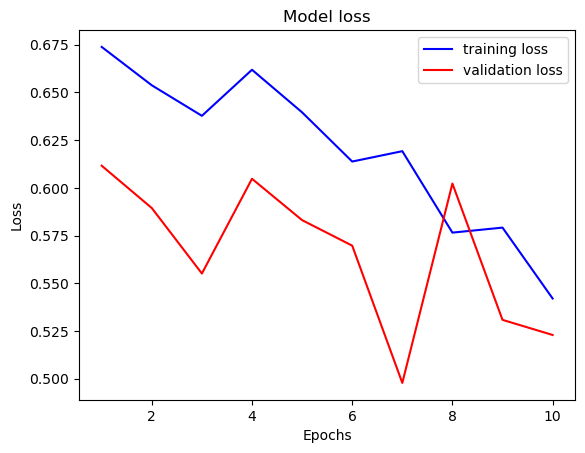

<Figure size 640x480 with 0 Axes>

In [41]:
plt.plot(epoch_range, loss, 'b', label='training loss')
plt.plot(epoch_range, val_loss, 'r', label='validation loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.figure()

<Figure size 640x480 with 0 Axes>

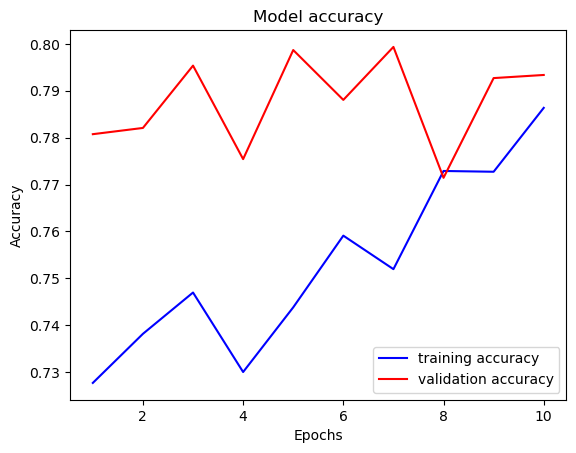

<Figure size 640x480 with 0 Axes>

In [42]:
plt.plot(epoch_range, acc, 'b', label='training accuracy')
plt.plot(epoch_range, val_acc, 'r', label='validation accuracy')
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()